# Two Populations (Section 4.5)

We next see that, if there exists a small subpopulation that falls out of the pattern set by the bulk of the data, both AMIP and Additive One-Exact can suffer Type 1 failures. This example was inspired by the two-data point example in Section 4.5.

In this example, the overall slope (across all data points) has a different sign than the slope in just the red data or just the black data. To create the illustration in \cref{}, we draw 1,000 red crosses with $x_n \sim \mathcal{N}(0,0.25)$ iid, $y_n = -x_n + \epsilon_n$, and $\epsilon_n \sim \mathcal{N}(0,1)$ iid. We draw 10 black dots, with $x_n \sim \mathcal{N}(0,50)$ iid, $y_n = x_n + \epsilon_n$, and $\epsilon_n \sim \mathcal{N}(0,1)$ iid. The OLS-estimated slope on the full dataset is 0.48. Dropping the black dots ($0.99\%$ of the data) yields a slope of -1.10, a sign change.

When asked to find the worst-case $0.99\%$ (i.e., 10 data points) of the dataset to drop, both AMIP and Additive One-Exact choose the 10 black dots, indicating a success in correctly identifying the Most Influential Set \cref{}. However, both methods underestimate the impact of dropping the Most Influential Set, resulting in a failure to detect the sign change (a Type-1 failure). Upon removing the flagged data points and re-running the data analysis, in both cases, the additive methods detect the sign change. Both greedy methods flag the 10 black-dots as the points to drop, so neither suffers a failure.

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from linear_regression import LinearRegression

In [70]:
# set random seed for reproducibility.
np.random.seed(6)

### Data Generation.

In [99]:
total_observations = 1010
num_observations_pop_1 = 10 # A
num_observations_pop_2 = total_observations - num_observations_pop_1 # B

# Generate X values.
mean_pop_1 = np.array([0])
mean_pop_2 = np.array([0])
vars_pop_1 = np.array([[50]])
vars_pop_2 = np.array([[0.25]])

x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)
x = np.append(x1, x2, axis=0)

# Add an intercept term.
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr
x1 = x[:num_observations_pop_1]
x2 = x[num_observations_pop_1:]

x1_0 = [pt[0] for pt in x1]
x1_1 = [pt[1] for pt in x1]
x2_0 = [pt[0] for pt in x2]
x2_1 = [pt[1] for pt in x2]

# Generate Y values.
epsilon1 = np.random.normal(0, 1, num_observations_pop_1)
slope1 = 1
intercept1 = 0
y1 = []
for i in range(num_observations_pop_1):
    y1.append(slope1*x1_1[i] + intercept1 + epsilon1[i])

epsilon2 = np.random.normal(0, 1, num_observations_pop_2)
slope2 = -1
intercept2 = 0
y2 = []
for i in range(num_observations_pop_2):
    y2.append(slope2*x2_1[i] + intercept2 + epsilon2[i])

y = np.concatenate([y1, y2], axis=0)


### Cross Leverage Computations.

In [1232]:
# Compute the inverse Covariance Matrix.
A = np.linalg.inv(x.T @ x)
# Compute the Hat Matrix.
H = x @ A @ x.T
# Compute the Least-Squares Estimator.
Betahat = np.linalg.inv(x.T @ x) @ x.T @ y

In [1233]:
# compute DFBETAs for the black dots.
dfbeta0 = 1/ (1 - H[0, 0]) * A @ x[0] * (y[0] - x[0].T @ Betahat)
dfbeta1 = 1/ (1 - H[1, 1]) * A @ x[1] * (y[1] - x[1].T @ Betahat)
print(f"DFBETA for the 1st black dot: {dfbeta0[1]}")
print(f"DFBETA for the 2nd black dot: {dfbeta1[1]}")
# compute residuals for the black dots.
residual0 = y[0] - x[0].T @ Betahat
residual1 = y[1] - x[1].T @ Betahat


DFBETA for the 1st black dot: 0.22983654726481254
DFBETA for the 2nd black dot: 0.22847334352590756


In [1235]:
black_dots_cross_leverage = x[0].T @ np.linalg.inv(x.T @ x) @ x[1]
print(f"Cross leverage score for the 2 black dots: {round(black_dots_cross_leverage, 4)}")
mean_cross_leverage = np.mean([x[i-1].T @ np.linalg.inv(x.T @ x) @ x[i] for i in range(3, len(x))])
print(f"Mean cross leverage score for the 1000 red crosses: {round(mean_cross_leverage, 4)}")

Cross leverage score for the 2 black dots: -0.4205
Mean cross leverage score for the 1000 red crosses: 0.001


In [1242]:
# compute the fit of the first black dot.
y1_pred_full = x1[0].T @ lr.beta
print(f'The fit of the bottom left black dot is {y1_pred_full}.')
# compute the fit of the first black dot with the second black dot removed.
y1_pred_noTR = x1[0].T @ lr_noTR.beta
print(f'The fit of the bottom left black dot with the top right black dot removed is {y1_pred_noTR}.')
# compute the difference in the fits.
y1_pred_diff = y1_pred_noTR - y1_pred_full
print(f'The impact of dropping the top right black dot on the fit of the bottom left black dot is {y1_pred_diff}.')

# compute the fit of the second black dot.
y2_pred_full = x1[1].T @ lr.beta
print(f'The fit of the top right black dot is {y2_pred_full}.')
# compute the fit of the second black dot with the first black dot removed.
y2_pred_noBL = x1[1].T @ lr_noBL.beta
print(f'The fit of the top right black dot with the bottom left black dot removed is {y2_pred_noBL}.')
# compute the difference in the fits.
y2_pred_diff = y2_pred_noBL - y2_pred_full
print(f'The impact of dropping the bottom left black dot on the fit of the top right black dot is {y2_pred_diff}.')

The fit of the bottom left black dot is -34.251043722504335.
The fit of the bottom left black dot with the top right black dot removed is -22.856436597273458.
The impact of dropping the top right black dot on the fit of the bottom left black dot is 11.394607125230877.
The fit of the top right black dot is 34.3580643692659.
The fit of the top right black dot with the bottom left black dot removed is 22.891417027918013.
The impact of dropping the bottom left black dot on the fit of the top right black dot is -11.466647341347883.


In [1243]:
min_distance = np.inf
for i in range(len(x2)):
    distance = np.sqrt((x1[0][1] - x2[i][1])**2 + (y1[0] - y2[i])**2)
    if distance < min_distance:
        min_distance = distance
print(f'The minimum distance between the lower left black dot and the closest red cross is {min_distance}.')

min_distance = np.inf
for i in range(len(x2)):
    distance = np.sqrt((x1[1][1] - x2[i][1])**2 + (y1[1] - y2[i])**2)
    if distance < min_distance:
        min_distance = distance
print(f'The minimum distance between the upper right black dot and the closest red cross is {min_distance}.')

print(f'The two black dots are around equidistant from the red crosses.')

The minimum distance between the lower left black dot and the closest red cross is [68.23850034].
The minimum distance between the upper right black dot and the closest red cross is [68.55925797].
The two black dots are around equidistant from the red crosses.


In [1247]:
print(f'The ratio of residuals is {residual0 / residual1} while the cross-leverage is {H[0,1]}.')

The ratio of residuals is -1.0068419055856026 while the cross-leverage is -0.42054803135618374.


### Model Fitting.

Fit the data using OLS regression.

In [98]:
lr = LinearRegression(x=x.T, y=y)
lr.fit()
lr_inliers = LinearRegression(x=x2.T, y=y2)
lr_inliers.fit()
lr_outliers = LinearRegression(x=x1.T, y=y1)
lr_outliers.fit()
print(
    f"Estimated beta for full data: {round(lr.beta[1], 4)} \n"
    f"Estimated beta for red crosses: {round(lr_inliers.beta[1], 4)} \n"
    f"Estimated beta for black dots: {round(lr_outliers.beta[1], 4)} \n"
)

Estimated beta for full data: 0.4809 
Estimated beta for red crosses: -1.1019 
Estimated beta for black dots: 0.9716 



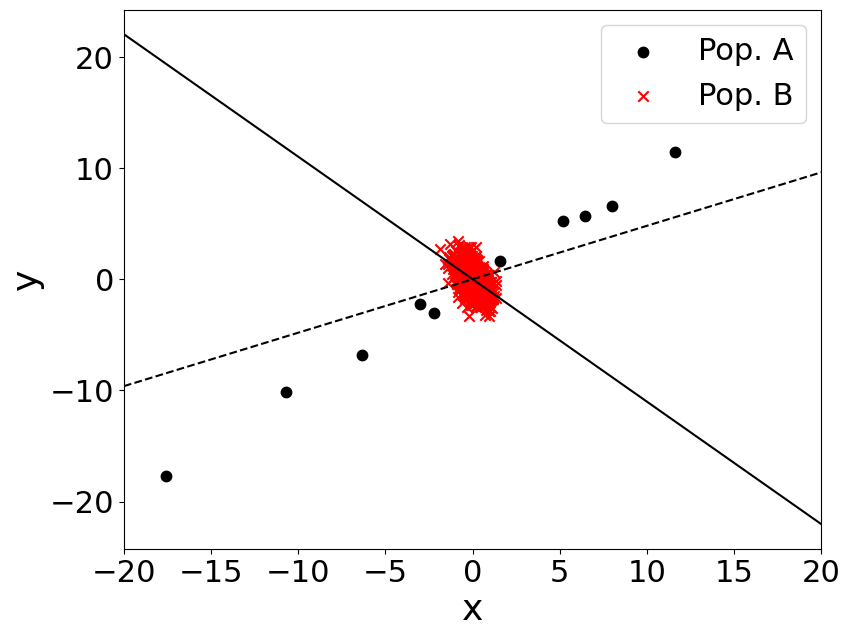

In [97]:
plt.figure(figsize=(9, 7))

plt.scatter(x1[:, 1], y1, marker='o', color='black', label='Pop. A', s=56)
plt.scatter(x2[:, 1], y2, marker='x', color='r', label='Pop. B', s=56)

x_values = np.linspace(-20, 20, 100)
y_values_full = lr.beta[1] * x_values
y_value_red_crosses = lr_inliers.beta[1] * x_values
plt.plot(x_values, y_values_full, color='black', linestyle='--') 
plt.plot(x_values, y_value_red_crosses, color='black')

plt.xlabel('x', fontsize=26) 
plt.ylabel('y', fontsize=26)

# set range of y-axis
# plt.ylim(-130, 130)
plt.xlim(-20, 20)

plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)

plt.legend(fontsize=22)
# plt.savefig('two_populations_outlier_example.pdf')
plt.show()

### Running Additive and Greedy algorithms.

In [74]:
def compute_scores(x, y, lr):
    '''
    x: design matrix.
    y: response vector.
    lr: linear regression model.
    '''
    if_scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order.
    if_inds = np.argsort(if_scores)
    newton_inds = np.argsort(newton_scores)

    # sort scores according to indices.
    sorted_scores = if_scores[if_inds]
    sorted_newton_scores = newton_scores[newton_inds]

    # compute residuals and leverages.
    residuals = lr.residual()
    leverages = lr.leverage_scores()

    x1 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x': x1, 'y': y, 
                            'residual': residuals, 'leverage': leverages, 
                            'IF': if_scores, '1Exact': newton_scores,
                            'sorted_IF_indices': if_inds, 'sorted_1Exact_indices': newton_inds,
                            'sorted_IF_scores': sorted_scores, 'sorted_1Exact_scores': sorted_newton_scores})
    return orig_df

#### Additive Algorithms.

In [103]:
OS_outliers_df = compute_scores(x, y, lr)

The additive approximations fail in the type 1 sense but succeed in the type 2 sense, because the indices of black dots are exactly the indices for the first 10 points to remove.

In [76]:
OS_outliers_df[:10]

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,-2.204643,-3.078366,-2.050956,0.005904,-0.004594,-0.004621,4,4,-0.166170,-0.243035
1,5.154836,5.224947,2.713283,0.028229,-0.014308,-0.014724,8,8,-0.069153,-0.080262
2,1.540226,1.636331,0.862884,0.003445,-0.001366,-0.001371,7,7,-0.054640,-0.061934
3,-6.357539,-6.829432,-3.804952,0.042115,-0.024654,-0.025738,3,3,-0.024654,-0.025738
4,-17.584195,-17.685503,-9.262277,0.316270,-0.166170,-0.243035,6,6,-0.021897,-0.023444
5,6.457663,5.676971,2.538794,0.043702,-0.016764,-0.017531,5,5,-0.016764,-0.017531
6,7.969544,6.553046,2.687828,0.066002,-0.021897,-0.023444,1,1,-0.014308,-0.014724
7,-10.706256,-10.119831,-5.004112,0.117776,-0.054640,-0.061934,0,0,-0.004594,-0.004621
8,11.591538,11.445433,5.838446,0.138410,-0.069153,-0.080262,9,9,-0.002541,-0.002567
9,-3.039807,-2.250575,-0.821546,0.010358,-0.002541,-0.002567,2,2,-0.001366,-0.001371


In [102]:
print(f'The AMIP approximation for the change induced by dropping the worst-case subset is {round(sum(OS_outliers_df["sorted_IF_scores"][:num_observations_pop_1]), 4)}.')
print(f'The Add-1Exact for the change induced by dropping the worst-case subset is {round(sum(OS_outliers_df["sorted_1Exact_scores"][:num_observations_pop_1]), 4)}.')
print(f'The true change induced by dropping the worst-case subset is {round((lr_inliers.beta[1] - lr.beta[1]), 4)}.')

print(f'The AMIP approximation of the refit is {round(lr.beta[1] + sum(OS_outliers_df["sorted_IF_scores"][:num_observations_pop_1]), 4)}.')
print(f'The Add-1Exact approximation of the refit is {round(lr.beta[1] + sum(OS_outliers_df["sorted_1Exact_scores"][:num_observations_pop_1]), 4)}.')
print(f'The true refit is {round((lr_inliers.beta[1]), 4)}.')

The AMIP approximation for the change induced by dropping the worst-case subset is -0.3761.
The Add-1Exact for the change induced by dropping the worst-case subset is -0.4752.
The true change induced by dropping the worst-case subset is -1.5828.
The AMIP approximation of the refit is 0.1048.
The Add-1Exact approximation of the refit is 0.0057.
The true refit is -1.1019.


#### Greedy Algorithms.

In [90]:
def create_orig_df(x, y, lr):
    '''
    x: design matrix.
    y: response vector.
    lr: linear regression object.
    '''
    # compute IF/1Exact scores.
    if_scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order.
    if_inds = np.argsort(if_scores)
    newton_inds = np.argsort(newton_scores)

    # residuals
    residuals = lr.residual()
    # leverages
    leverages = lr.leverage_scores()
    # x's
    x1 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x1': x1, 'y': y, 
                                      'residual': residuals, 'leverage': leverages, 
                            'influence': if_scores, 'newton': newton_scores})
    
    print(orig_df[:5])
    return orig_df, if_inds, if_scores, newton_inds, newton_scores

def create_plot(orig_df, num_observations_pop_1):
    '''
    orig_df: output from the helper function above.
    '''

    # Sort DF by influence score
    sorted_if_df = orig_df.sort_values(by='influence', ascending=True)
    print("Point to Drop: ", sorted_if_df.index[0])
    
    # sorted_if_df: the indices here are the order which amip drops points.
    index = range(0, len(sorted_if_df))
    sorted_if_df['sorted_idx'] = index
    
    # Plot points dropped
    plt.figure(figsize=(9, 7))
    plt.scatter(orig_df[:num_observations_pop_1]['x1'], orig_df[:num_observations_pop_1]['y'], marker='x', color='black', label='Pop. A') # pop A
    plt.scatter(orig_df[num_observations_pop_1:]['x1'], orig_df[num_observations_pop_1:]['y'], marker='x', color='r', label='Pop. B') # pop B

    # Add dropped order positioned by each point
    for index, row in sorted_if_df.iterrows():
        if row['sorted_idx'] <= 9: # indices 2,3,4 are right on top of one another.
            plt.text(row['x1'], row['y'], int(row['sorted_idx']), ha='left', va='top', fontsize=20)


    plt.xlabel('x1')
    plt.ylabel('y')
    plt.title('Scores Ordered')
    plt.legend()
    plt.show()
    
    return

def Run_Greedy(num_observations_pop_1, x, y, orig_if_inds, orig_newton_inds, lr, num_iter, method='IF'):
    '''
    num_observations_pop_1: number of black dot points.
    x: design matrix.
    y: response vector.
    orig_inds: indices sorted by the first round.
    lr: linear regression object.
    method: 'IF' or '1Exact'.
    num_iter: number of iterations.
    '''
    ctr = 0
    prev_beta = lr.beta[1] # initialize to the original beta estimate.
    dropped_order = []
    exact_changes_beta = []
    beta_estimates_greedy = []
    if_inds = orig_if_inds
    newton_inds = orig_newton_inds

    for _ in range(num_iter):
        print(f'interation {ctr}')

        if method == 'IF':
            inds = if_inds
        else:
            inds = newton_inds
        
        # 1. drop the datapoint with the most negative influence:
        index_to_remove = inds[0]
        print("index to remove", index_to_remove)

        dropped_order.append(index_to_remove)

        new_x = np.concatenate((x[:index_to_remove], x[index_to_remove + 1:]))
        new_y = np.concatenate((y[:index_to_remove], y[index_to_remove + 1:]))

        x = new_x
        y = new_y

        # 2. calculate the exact perturbation (ie. refit the lr to get the change in the coefficient.)
        lr = LinearRegression(x=x.T, y=y)
        lr.fit()
        print(f'fitted beta1: {lr.beta[1]}')

        # 3. compute scores and create plot.
        orig_df, if_inds, if_scores, newton_inds, newton_scores = create_orig_df(x, y, lr)
        create_plot(orig_df, num_observations_pop_1)

        # 4. record: the exact change in beta.
        beta_change = lr.beta[1] - prev_beta
        exact_changes_beta.append(beta_change)
        prev_beta = lr.beta[1]
        beta_estimates_greedy.append(lr.beta[1])

        # counter
        ctr += 1

    return dropped_order, exact_changes_beta, beta_estimates_greedy

In [91]:
# store the original x and y.
orig_x = x
orig_y = y

# compute scores for initial round of the greedy algorithm.
orig_df, if_inds, if_scores, newton_inds, newton_scores = create_orig_df(orig_x, orig_y, lr)

orig_inds_if = if_inds
orig_inds_newton = newton_inds
# compute influence scores.
if_scores = -lr.influence_scores()[1]
# sort indices in ascending order.
if_inds = np.argsort(if_scores)
print("inds", if_inds[:10])
newton_inds = np.argsort(newton_scores)
print("newton_inds", newton_inds[:10])

# reset greedy loop.
x = orig_x
y = orig_y

          x1          y  residual  leverage  influence    newton
0  -2.204643  -3.078366 -2.050956  0.005904  -0.004594 -0.004621
1   5.154836   5.224947  2.713283  0.028229  -0.014308 -0.014724
2   1.540226   1.636331  0.862884  0.003445  -0.001366 -0.001371
3  -6.357539  -6.829432 -3.804952  0.042115  -0.024654 -0.025738
4 -17.584195 -17.685503 -9.262277  0.316270  -0.166170 -0.243035
inds [4 8 7 3 6 5 1 0 9 2]
newton_inds [4 8 7 3 6 5 1 0 9 2]


Both greedy algorithms succeed.

interation 0
index to remove 4
fitted beta1: 0.2378513940048217
         x1         y  residual  leverage  influence    newton
0 -2.204643 -3.078366 -2.597601  0.008286  -0.008569 -0.008640
1  5.154836  5.224947  3.955249  0.040522  -0.030372 -0.031655
2  1.540226  1.636331  1.226374  0.004498  -0.002805 -0.002818
3 -6.357539 -6.829432 -5.360896  0.061410  -0.050892 -0.054222
4  6.457663  5.676971  4.097393  0.063063  -0.039426 -0.042080
Point to Drop:  7


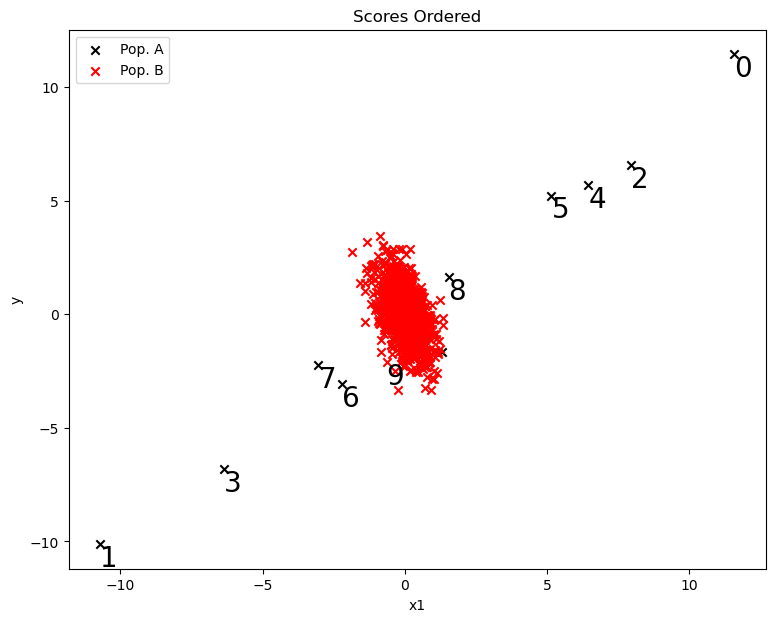

interation 1
index to remove 7
fitted beta1: 0.050849300762129374
         x1         y  residual  leverage  influence    newton
0 -2.204643 -3.078366 -3.000426  0.010021  -0.012313 -0.012438
1  5.154836  5.224947  4.928662  0.050651  -0.047437 -0.049968
2  1.540226  1.636331  1.523847  0.005444  -0.004392 -0.004416
3 -6.357539 -6.829432 -6.540320  0.076279  -0.077508 -0.083909
4  6.457663  5.676971  5.314438  0.078895  -0.064066 -0.069553
Point to Drop:  6


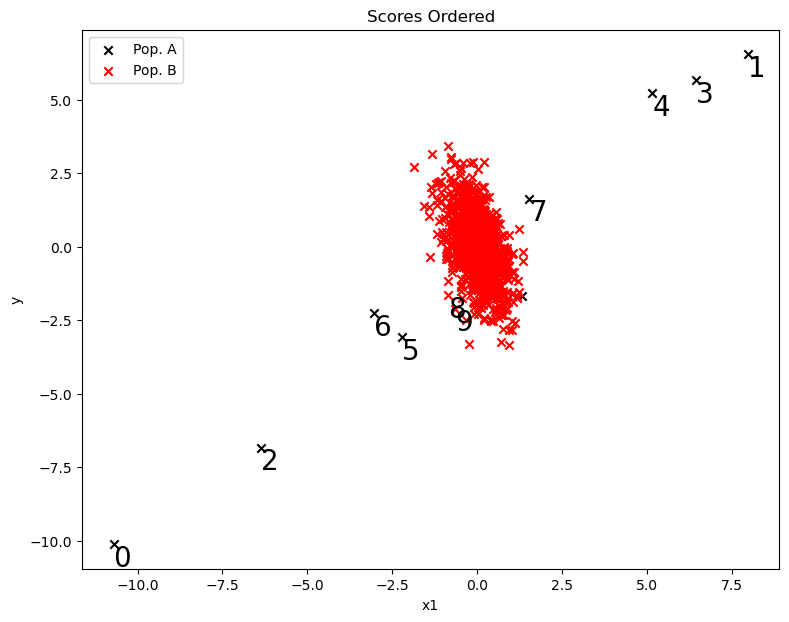

interation 2
index to remove 6
fitted beta1: -0.19341272142138877
         x1         y  residual  leverage  influence    newton
0 -2.204643 -3.078366 -3.549936  0.012589  -0.018621 -0.018858
1  5.154836  5.224947  6.176793  0.063900  -0.075465 -0.080617
2  1.540226  1.636331  1.889066  0.006579  -0.006877 -0.006923
3 -6.357539 -6.829432 -8.104225  0.097080  -0.122371 -0.135528
4  6.457663  5.676971  6.880801  0.099762  -0.105338 -0.117011
Point to Drop:  5


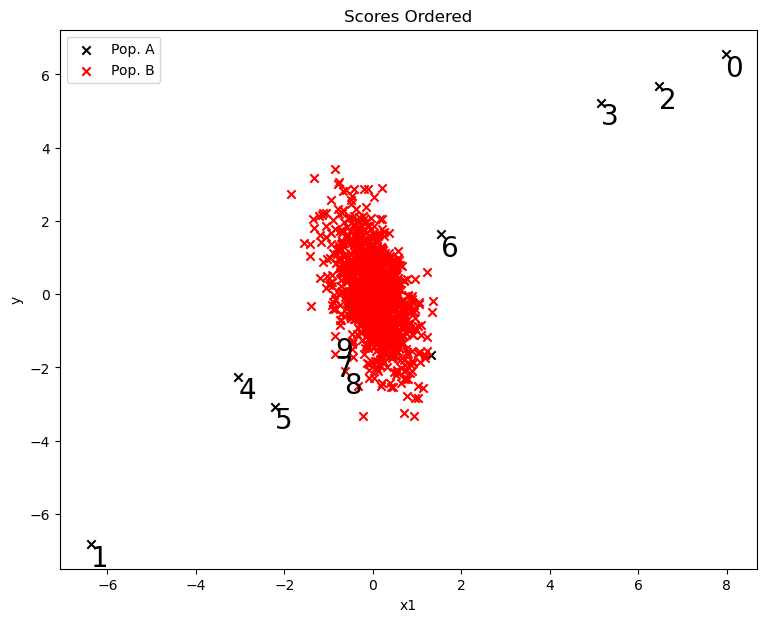

interation 3
index to remove 5
fitted beta1: -0.3726687511914843
         x1         y  residual  leverage  influence    newton
0 -2.204643 -3.078366 -3.936780  0.014549  -0.024225 -0.024583
1  5.154836  5.224947  7.109180  0.075285  -0.102418 -0.110756
2  1.540226  1.636331  2.173512  0.007638  -0.009364 -0.009436
3 -6.357539 -6.829432 -9.235501  0.113840  -0.163981 -0.185046
4  6.457663  5.676971  8.046727  0.117565  -0.145212 -0.164558
Point to Drop:  3


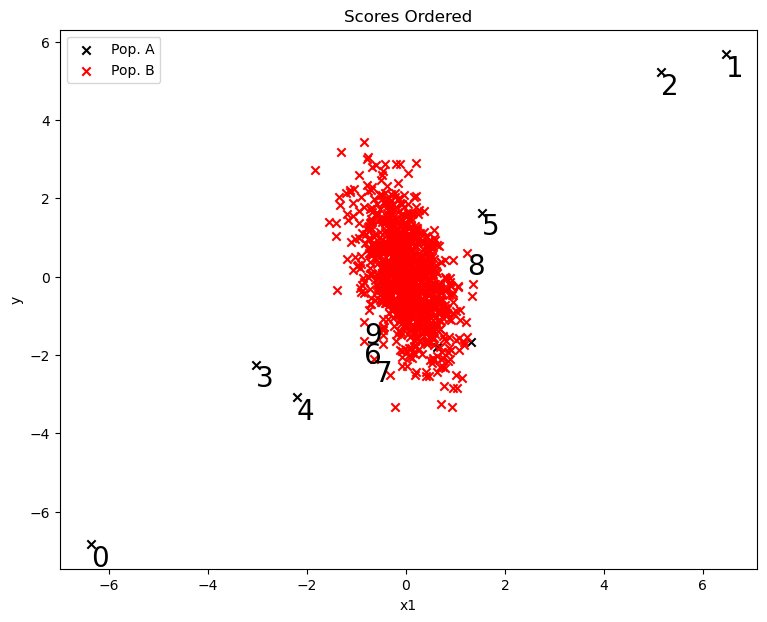

interation 4
index to remove 3
fitted beta1: -0.5577150185122566
         x1         y  residual  leverage  influence    newton
0 -2.204643 -3.078366 -4.354740  0.016363  -0.030297 -0.030801
1  5.154836  5.224947  8.053065  0.084541  -0.130629 -0.142692
2  1.540226  1.636331  2.448527  0.008424  -0.011844 -0.011944
3  6.457663  5.676971  9.231695  0.132153  -0.187627 -0.216198
4 -3.039807 -2.250575 -3.992732  0.030181  -0.038280 -0.039471
Point to Drop:  3


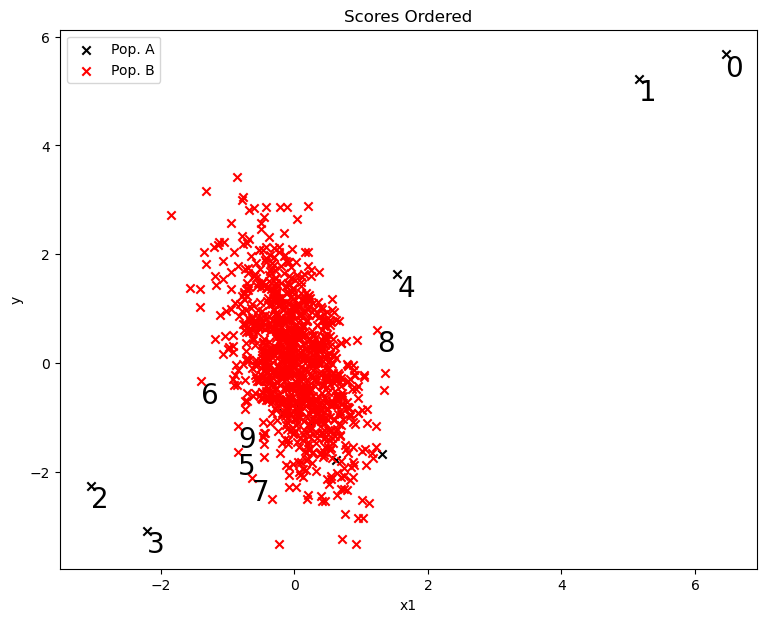

interation 5
index to remove 3
fitted beta1: -0.7739131275630208
         x1         y  residual  leverage  influence    newton
0 -2.204643 -3.078366 -4.821740  0.018584  -0.038503 -0.039232
1  5.154836  5.224947  9.177170  0.097408  -0.171575 -0.190091
2  1.540226  1.636331  2.791160  0.009620  -0.015606 -0.015758
3 -3.039807 -2.250575 -4.640293  0.034451  -0.051104 -0.052927
4  1.315640 -1.667143 -0.686124  0.007291   0.003278  0.003302
Point to Drop:  1


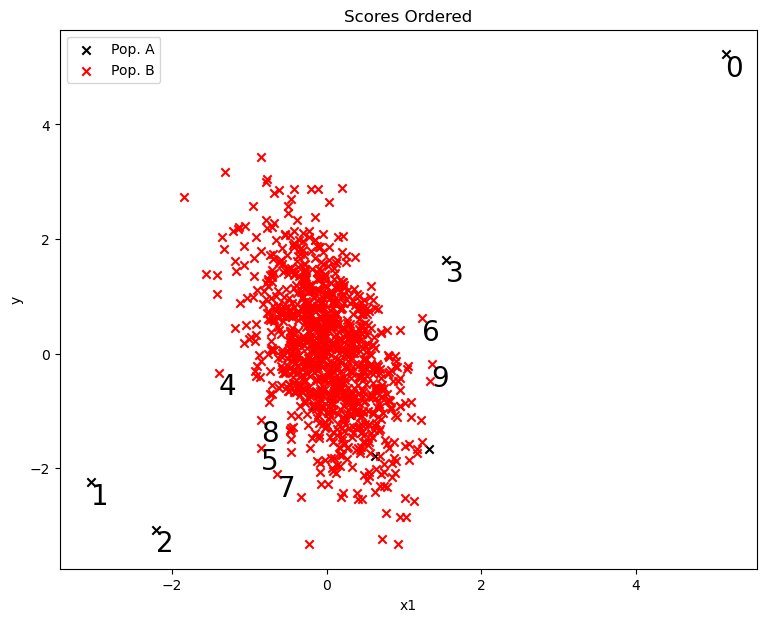

interation 6
index to remove 1
fitted beta1: -0.9640044719664372
         x1         y  residual  leverage  influence    newton
0 -2.204643 -3.078366 -5.230306  0.020373  -0.046119 -0.047078
1  1.540226  1.636331  3.094461  0.010605  -0.019214 -0.019420
2 -3.039807 -2.250575 -5.207616  0.037900  -0.063371 -0.065867
3  1.315640 -1.667143 -0.425514  0.008019   0.002259  0.002277
4  0.300911 -1.067556 -0.804131  0.001378   0.000994  0.000996
Point to Drop:  2


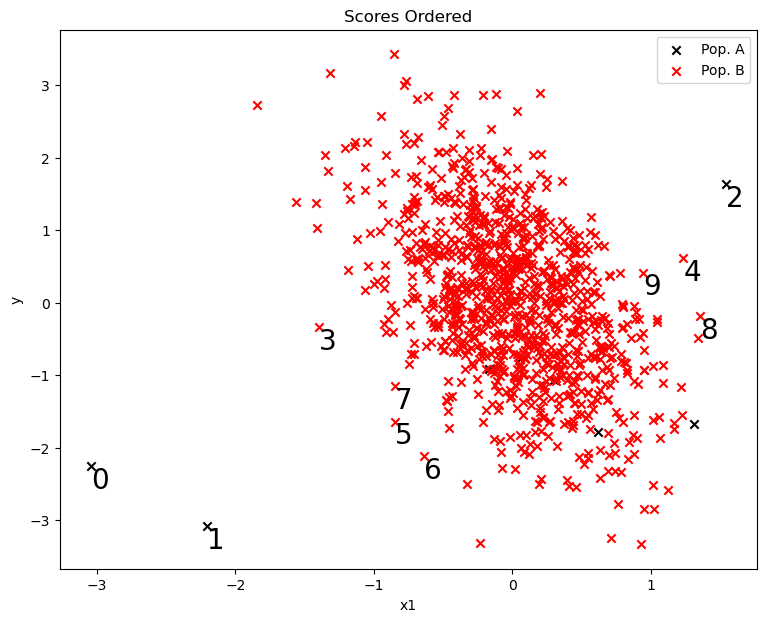

interation 7
index to remove 2
fitted beta1: -1.0298715096273416
         x1         y  residual  leverage  influence    newton
0 -2.204643 -3.078366 -5.380442  0.021173  -0.049330 -0.050397
1  1.540226  1.636331  3.190989  0.010936  -0.020534 -0.020761
2  1.315640 -1.667143 -0.343779  0.008256   0.001890  0.001906
3  0.300911 -1.067556 -0.789233  0.001386   0.001003  0.001005
4 -0.167941 -0.917235 -1.121769  0.001110  -0.000765 -0.000766
Point to Drop:  0


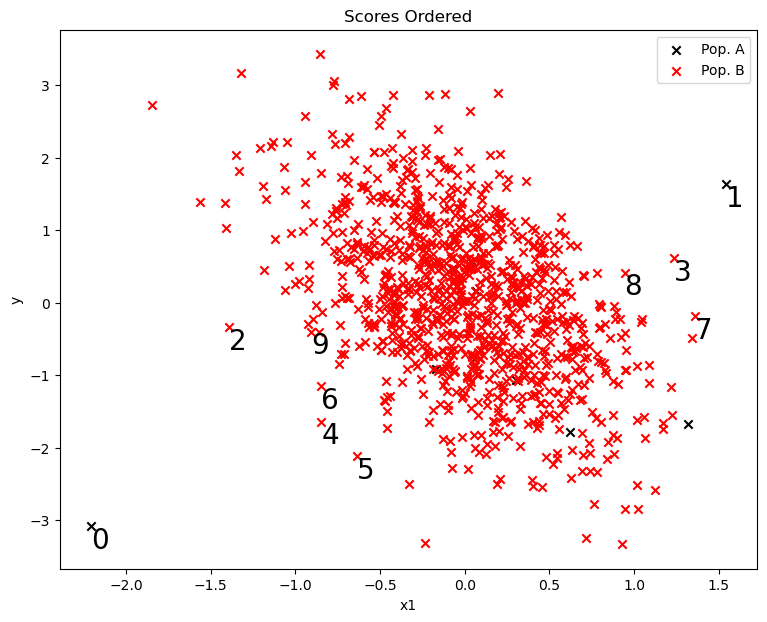

interation 8
index to remove 0
fitted beta1: -1.0802688275396481
         x1         y  residual  leverage  influence    newton
0  1.540226  1.636331  3.263337  0.011113  -0.021401 -0.021642
1  1.315640 -1.667143 -0.282750  0.008382   0.001584  0.001598
2  0.300911 -1.067556 -0.779343  0.001389   0.001004  0.001005
3 -0.167941 -0.917235 -1.135508  0.001116  -0.000801 -0.000802
4  0.618869 -1.786804 -1.155112  0.002638   0.003050  0.003058
Point to Drop:  0


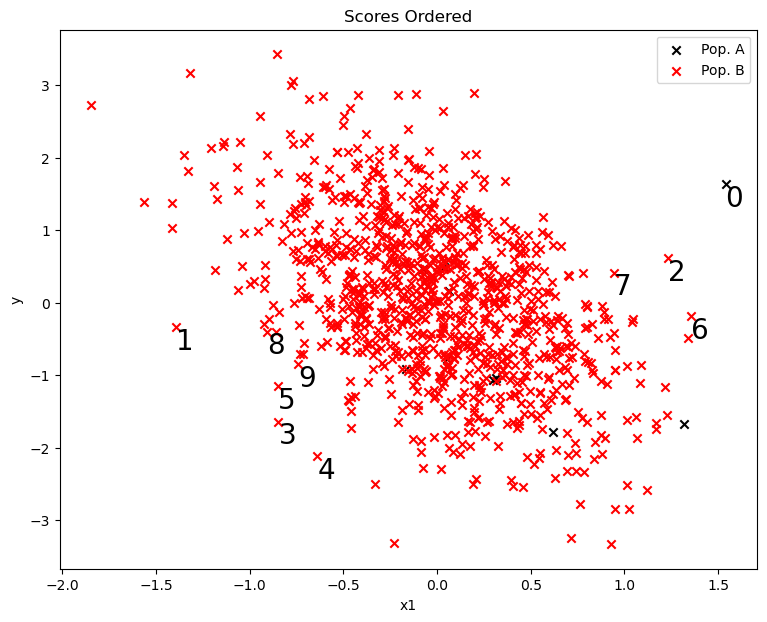

interation 9
index to remove 0
fitted beta1: -1.1019107176198848
         x1         y  residual  leverage  influence    newton
0  1.315640 -1.667143 -0.250938  0.008476   0.001422  0.001434
1  0.300911 -1.067556 -0.769492  0.001398   0.001006  0.001008
2 -0.167941 -0.917235 -1.135804  0.001116  -0.000802 -0.000803
3  0.618869 -1.786804 -1.138379  0.002664   0.003044  0.003052
4  0.055564 -0.781375 -0.753662  0.001015   0.000191  0.000191
Point to Drop:  805


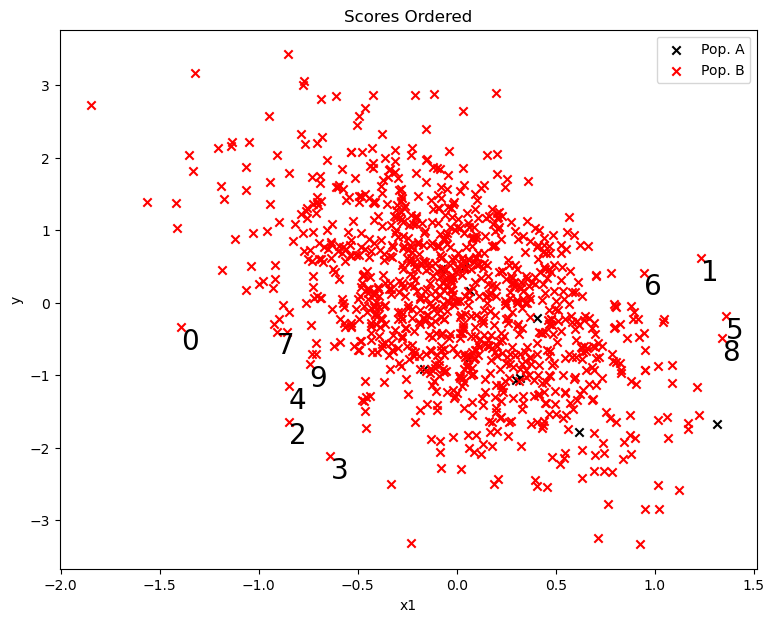

dropped order: 
 [4, 7, 6, 5, 3, 3, 1, 2, 0, 0]
exact (greedy) beta estimates: 
 [0.2378513940048217, 0.050849300762129374, -0.19341272142138877, -0.3726687511914843, -0.5577150185122566, -0.7739131275630208, -0.9640044719664372, -1.0298715096273416, -1.0802688275396481, -1.1019107176198848]


In [95]:
num_observations_pop_1=10
num_iter=10
# Run Greedy
dropped_order, exact_changes_beta, beta_estimates_greedy = Run_Greedy(num_observations_pop_1, orig_x, orig_y, orig_inds_if, orig_inds_newton, lr, num_iter, method='IF')

print("dropped order: \n", dropped_order[:num_observations_pop_1])
print("exact (greedy) beta estimates: \n", beta_estimates_greedy[:num_observations_pop_1])